In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("~/projects/us-education-datasets-unification-project/data/us-education-datasets-unification-project/states_all.csv")
df_orig = df.copy()

In [4]:
df.shape

(1492, 25)

In [5]:
print('THERE ARE OUTLIERS PRESENT THAT NEED TO BE REMOVED')
print('There are: ')
print(df['PRIMARY_KEY'].duplicated(keep=False).sum(), 'duplicated PRIMARY_KEY s')
print('Unique duplicated keys: \n', df[df['PRIMARY_KEY'].duplicated(keep=False)]['PRIMARY_KEY'].unique())
df[df['PRIMARY_KEY'].duplicated(keep=False)]

THERE ARE OUTLIERS PRESENT THAT NEED TO BE REMOVED
There are: 
9 duplicated PRIMARY_KEY s
Unique duplicated keys: 
 ['2008_DISTRICT_OF_COLUMBIA' '2008_VIRGINIA' '2009_DISTRICT_OF_COLUMBIA'
 '2010_DISTRICT_OF_COLUMBIA']


,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
824,2008_DISTRICT_OF_COLUMBIA,DISTRICT_OF_COLUMBIA,2008,58191.0,1224312.0,85568.0,0.0,1138744.0,1224785.0,520090.0,...,3292.0,2936.0,2092.0,26249.0,10315.0,36676.0,NaN,NaN,NaN,NaN
825,2008_DISTRICT_OF_COLUMBIA,DISTRICT_OF_COLUMBIA,2008,58191.0,1224312.0,85568.0,0.0,1138744.0,1224785.0,520090.0,...,4595.0,4540.0,3444.0,38190.0,17891.0,63532.0,NaN,NaN,NaN,NaN
863,2008_VIRGINIA,VIRGINIA,2008,1230857.0,14768120.0,897627.0,5957786.0,7912707.0,15236306.0,8003167.0,...,4666.0,3863.0,2535.0,36807.0,12837.0,51345.0,NaN,NaN,NaN,NaN
864,2008_VIRGINIA,VIRGINIA,2008,1230857.0,14768120.0,897627.0,5957786.0,7912707.0,15236306.0,8003167.0,...,2548.0,1485.0,484.0,19226.0,2758.0,24554.0,NaN,NaN,NaN,NaN
865,2008_VIRGINIA,VIRGINIA,2008,1230857.0,14768120.0,897627.0,5957786.0,7912707.0,15236306.0,8003167.0,...,91133.0,92881.0,87177.0,735090.0,380787.0,1145864.0,NaN,NaN,NaN,NaN
878,2009_DISTRICT_OF_COLUMBIA,DISTRICT_OF_COLUMBIA,2009,44331.0,801008.0,75856.0,0.0,725152.0,805362.0,330698.0,...,4893.0,4452.0,3301.0,37698.0,17597.0,63794.0,219.260141,253.595187,201.984638,252.631381
879,2009_DISTRICT_OF_COLUMBIA,DISTRICT_OF_COLUMBIA,2009,44331.0,801008.0,75856.0,0.0,725152.0,805362.0,330698.0,...,3423.0,2860.0,2188.0,26762.0,9970.0,36823.0,219.260141,253.595187,201.984638,252.631381
930,2010_DISTRICT_OF_COLUMBIA,DISTRICT_OF_COLUMBIA,2010,43866.0,1195934.0,80585.0,0.0,1115349.0,1290048.0,526469.0,...,3397.0,2992.0,2203.0,27264.0,9977.0,NaN,NaN,NaN,NaN,NaN
931,2010_DISTRICT_OF_COLUMBIA,DISTRICT_OF_COLUMBIA,2010,43866.0,1195934.0,80585.0,0.0,1115349.0,1290048.0,526469.0,...,4877.0,4307.0,3407.0,37867.0,17632.0,65080.0,NaN,NaN,NaN,NaN


In [7]:
df['avg_total_expenditure'] = df['TOTAL_EXPENDITURE'] / df['GRADES_ALL_G']
print('2 rows have unreasonably high avg_total_expenditure')
df[df['avg_total_expenditure'] > 100]
drop_rows= df[df['avg_total_expenditure'] > 100].index.to_list()
print(drop_rows)

2 rows have unreasonably high avg_total_expenditure
[863, 864]


/Users/daviderickson/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/daviderickson/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


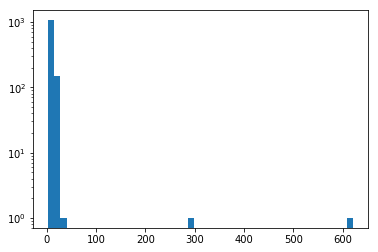

Before drop: (1492, 30)
After drop: (1490, 30)


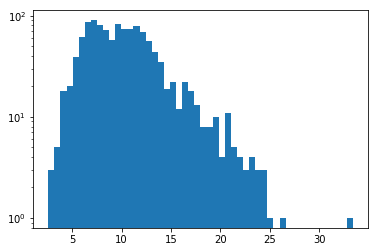

THERE ARE OUTLIERS PRESENT THAT NEED TO BE REMOVED
There are: 
6 duplicated PRIMARY_KEY s
Unique duplicated keys: 
 ['2008_DISTRICT_OF_COLUMBIA' '2009_DISTRICT_OF_COLUMBIA'
 '2010_DISTRICT_OF_COLUMBIA']


,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE,avg_total_revenue,fracn_schoolage,rev_per_person,exp_per_rev,avg_total_expenditure
824,2008_DISTRICT_OF_COLUMBIA,DISTRICT_OF_COLUMBIA,2008,58191.0,1224312.0,85568.0,0.0,1138744.0,1224785.0,520090.0,...,36676.0,NaN,NaN,NaN,NaN,33.381830,0.630269,21.039542,1.000386,33.394727
825,2008_DISTRICT_OF_COLUMBIA,DISTRICT_OF_COLUMBIA,2008,58191.0,1224312.0,85568.0,0.0,1138744.0,1224785.0,520090.0,...,63532.0,NaN,NaN,NaN,NaN,19.270793,1.091784,21.039542,1.000386,19.278238
878,2009_DISTRICT_OF_COLUMBIA,DISTRICT_OF_COLUMBIA,2009,44331.0,801008.0,75856.0,0.0,725152.0,805362.0,330698.0,...,63794.0,219.260141,253.595187,201.984638,252.631381,12.556165,1.439038,18.068801,1.005436,12.624416
879,2009_DISTRICT_OF_COLUMBIA,DISTRICT_OF_COLUMBIA,2009,44331.0,801008.0,75856.0,0.0,725152.0,805362.0,330698.0,...,36823.0,219.260141,253.595187,201.984638,252.631381,21.752926,0.830638,18.068801,1.005436,21.871167
930,2010_DISTRICT_OF_COLUMBIA,DISTRICT_OF_COLUMBIA,2010,43866.0,1195934.0,80585.0,0.0,1115349.0,1290048.0,526469.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.263347,1.078695,NaN
931,2010_DISTRICT_OF_COLUMBIA,DISTRICT_OF_COLUMBIA,2010,43866.0,1195934.0,80585.0,0.0,1115349.0,1290048.0,526469.0,...,65080.0,NaN,NaN,NaN,NaN,18.376368,1.483609,27.263347,1.078695,19.822495


In [8]:
plt.hist('avg_total_expenditure', bins=50, log=True, data=df);
plt.show()


# Drop the 2 outlier rows
print('Before drop:', df.shape)
df.drop(axis=0, labels= drop_rows, inplace=True)
print('After drop:', df.shape)

plt.hist('avg_total_expenditure', bins=50, log=True, data=df);
plt.show()

print('THERE ARE OUTLIERS PRESENT THAT NEED TO BE REMOVED')
print('There are: ')
print(df['PRIMARY_KEY'].duplicated(keep=False).sum(), 'duplicated PRIMARY_KEY s')
print('Unique duplicated keys: \n', df[df['PRIMARY_KEY'].duplicated(keep=False)]['PRIMARY_KEY'].unique())
df[df['PRIMARY_KEY'].duplicated(keep=False)]

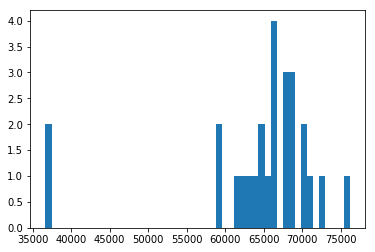

2 rows in DISTRICT_OF_COLUMBIAs data have unreasonably small GRADES_ALL_G


In [9]:
hist_df = df[df['STATE']=='DISTRICT_OF_COLUMBIA']
plt.hist('GRADES_ALL_G', data=hist_df, log=False, bins=50);
plt.show()

print('2 rows in DISTRICT_OF_COLUMBIAs data have unreasonably small GRADES_ALL_G')

In [10]:
print('These DISTRICT_OF_COLUMBIA duplicated keys have unreasonably small GRADES_ALL_G')
print(df[ (df['STATE'] == 'DISTRICT_OF_COLUMBIA') & (df['GRADES_ALL_G'] <  40000)]['GRADES_ALL_G'])
df[ (df['STATE'] == 'DISTRICT_OF_COLUMBIA') & (df['GRADES_ALL_G'] <  40000)]

These DISTRICT_OF_COLUMBIA duplicated keys have unreasonably small GRADES_ALL_G
824    36676.0
879    36823.0
Name: GRADES_ALL_G, dtype: float64


,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE,avg_total_revenue,fracn_schoolage,rev_per_person,exp_per_rev,avg_total_expenditure
824,2008_DISTRICT_OF_COLUMBIA,DISTRICT_OF_COLUMBIA,2008,58191.0,1224312.0,85568.0,0.0,1138744.0,1224785.0,520090.0,...,36676.0,NaN,NaN,NaN,NaN,33.381830,0.630269,21.039542,1.000386,33.394727
879,2009_DISTRICT_OF_COLUMBIA,DISTRICT_OF_COLUMBIA,2009,44331.0,801008.0,75856.0,0.0,725152.0,805362.0,330698.0,...,36823.0,219.260141,253.595187,201.984638,252.631381,21.752926,0.830638,18.068801,1.005436,21.871167


In [11]:
print('Drop these bad rows.')
print('Before drop df.shape=', df.shape)

drop_index= df[(df['STATE'] == 'DISTRICT_OF_COLUMBIA') & (df['GRADES_ALL_G'] <  40000)].index.to_list()
print(drop_index)

df.drop(axis=0, labels= drop_index, inplace=True)
print('After drop df.shape=', df.shape)

Drop these bad rows.
Before drop df.shape= (1490, 30)
[824, 879]
After drop df.shape= (1488, 30)


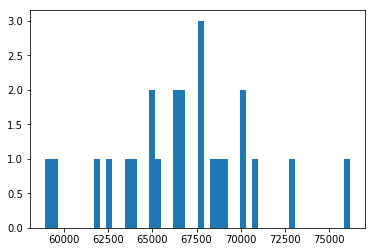

REMOVED: 2 rows in DISTRICT_OF_COLUMBIAs data HAD unreasonably small GRADES_ALL_G


In [12]:
hist_df = df[df['STATE']=='DISTRICT_OF_COLUMBIA']
plt.hist('GRADES_ALL_G', data=hist_df, log=False, bins=50);
plt.show()

print('REMOVED: 2 rows in DISTRICT_OF_COLUMBIAs data HAD unreasonably small GRADES_ALL_G')

In [13]:
print(df.shape, df_orig.shape)

(1488, 30) (1492, 25)


In [14]:
print('THERE ARE OUTLIERS PRESENT THAT NEED TO BE REMOVED')
print('There are: ')
print(df['PRIMARY_KEY'].duplicated(keep=False).sum(), 'duplicated PRIMARY_KEY s')
print('Unique duplicated keys: \n', df[df['PRIMARY_KEY'].duplicated(keep=False)]['PRIMARY_KEY'].unique())
df[df['PRIMARY_KEY'].duplicated(keep=False)]

THERE ARE OUTLIERS PRESENT THAT NEED TO BE REMOVED
There are: 
2 duplicated PRIMARY_KEY s
Unique duplicated keys: 
 ['2010_DISTRICT_OF_COLUMBIA']


,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE,avg_total_revenue,fracn_schoolage,rev_per_person,exp_per_rev,avg_total_expenditure
930,2010_DISTRICT_OF_COLUMBIA,DISTRICT_OF_COLUMBIA,2010,43866.0,1195934.0,80585.0,0.0,1115349.0,1290048.0,526469.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.263347,1.078695,NaN
931,2010_DISTRICT_OF_COLUMBIA,DISTRICT_OF_COLUMBIA,2010,43866.0,1195934.0,80585.0,0.0,1115349.0,1290048.0,526469.0,...,65080.0,NaN,NaN,NaN,NaN,18.376368,1.483609,27.263347,1.078695,19.822495


In [15]:
print('The rows are identical except that one has NaN s in place of entries in some columns')
print('Drop the row with more NaN s')

drop_rows= df[(df['PRIMARY_KEY'] == '2010_DISTRICT_OF_COLUMBIA') & (df['GRADES_ALL_G'].isnull()) ].index.to_list()

df[(df['PRIMARY_KEY'] == '2010_DISTRICT_OF_COLUMBIA') & (df['GRADES_ALL_G'].isnull()) ]

The rows are identical except that one has NaN s in place of entries in some columns
Drop the row with more NaN s


,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE,avg_total_revenue,fracn_schoolage,rev_per_person,exp_per_rev,avg_total_expenditure
930,2010_DISTRICT_OF_COLUMBIA,DISTRICT_OF_COLUMBIA,2010,43866.0,1195934.0,80585.0,0.0,1115349.0,1290048.0,526469.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.263347,1.078695,NaN


In [16]:

print('Shape before: ', df.shape)
df.drop(axis=0, labels=drop_rows, inplace=True)
print('Shape after: ', df.shape)


Shape before:  (1488, 30)
Shape after:  (1487, 30)


In [17]:
print('THERE ARE OUTLIERS PRESENT THAT NEED TO BE REMOVED')
print('There are: ')
print(df['PRIMARY_KEY'].duplicated(keep=False).sum(), 'duplicated PRIMARY_KEY s')
print('Unique duplicated keys: \n', df[df['PRIMARY_KEY'].duplicated(keep=False)]['PRIMARY_KEY'].unique())
df[df['PRIMARY_KEY'].duplicated(keep=False)]

THERE ARE OUTLIERS PRESENT THAT NEED TO BE REMOVED
There are: 
0 duplicated PRIMARY_KEY s
Unique duplicated keys: 
 []


,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE,avg_total_revenue,fracn_schoolage,rev_per_person,exp_per_rev,avg_total_expenditure


In [22]:
print('Remove non-Original columns')
print('Shape before: ', df.shape)
df = df[df_orig.columns]
print('Shape after: ', df.shape)

Remove non-Original columns
Shape before:  (1487, 30)
Shape after:  (1487, 25)


In [18]:
print(len(df_orig) - len(df), ' rows removed')
print('Original: ', df_orig.shape)
print('Final: ', df.shape)

5  rows removed
Original:  (1492, 25)
Final:  (1487, 30)


In [19]:
df.to_csv("~/projects/us-education-datasets-unification-project/data/us-education-datasets-unification-project/states_all-cleaned.csv")